In [439]:
import glob 
import numpy as np
import pandas as pd
import os
import cv2
from tqdm import tqdm

import pydicom
from pydicom.filebase import DicomBytesIO
from pydicom.pixel_data_handlers import apply_windowing

import dicomsdl

from nvidia.dali.backend import TensorGPU, TensorListGPU
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types
from nvidia.dali.types import DALIDataType

import torch
import torch.nn.functional as F


import matplotlib
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
Config = {
    'dcm_dir': '/home/data4/share/rsna-breast-cancer-detection/train_images',
    'output_dim_x' : 512,
    'output_dim_y' : 1024,
    'output_extension' : 'png',
    'skip_small_ROIs': True,
    'skip_unrecognized': True,
    'avoid_stretches': True
}

In [3]:
df = pd.read_csv("/home/data4/share/rsna-breast-cancer-detection/train.csv")
df['dcm_path'] = Config['dcm_dir'] + '/' + df.patient_id.astype(str) + '/' + df.image_id.astype(str) + '.dcm'
df.loc[df['site_id'] == 2, 'type'] = "j2k"
df.loc[df['site_id'] == 1, 'type'] = "jpg"

print(len( df[df["type"] == "j2k"]), len( df[df["type"] == "jpg"]))

25187 29519


In [4]:
df_j2k = df[df["type"]=="j2k"].copy().reset_index(drop=True)
df_j2k.tail()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,dcm_path,type
25182,2,9967,1260162631,R,CC,62.0,0,0,0,NaN,0,NaN,48,False,/home/data4/share/rsna-breast-cancer-detection...,j2k
25183,2,9968,766198919,L,CC,76.0,0,0,0,NaN,0,NaN,48,False,/home/data4/share/rsna-breast-cancer-detection...,j2k
25184,2,9968,2098937312,L,MLO,76.0,0,0,0,NaN,0,NaN,48,False,/home/data4/share/rsna-breast-cancer-detection...,j2k
25185,2,9968,294168046,R,MLO,76.0,0,0,0,NaN,0,NaN,48,False,/home/data4/share/rsna-breast-cancer-detection...,j2k
25186,2,9968,568005453,R,CC,76.0,0,0,0,NaN,0,NaN,48,False,/home/data4/share/rsna-breast-cancer-detection...,j2k


In [5]:
df_jpg = df[df["type"]=="jpg"].copy().reset_index(drop=True)
df_jpg.tail()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,dcm_path,type
29514,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False,/home/data4/share/rsna-breast-cancer-detection...,jpg
29515,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False,/home/data4/share/rsna-breast-cancer-detection...,jpg
29516,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False,/home/data4/share/rsna-breast-cancer-detection...,jpg
29517,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True,/home/data4/share/rsna-breast-cancer-detection...,jpg
29518,1,9989,439796429,R,CC,60.0,0,0,0,0.0,0,C,216,True,/home/data4/share/rsna-breast-cancer-detection...,jpg


In [35]:
rsna_768_images = glob.glob("./rsna_768_png/*.png")
rsna_768_images

['./rsna_768_png/10038_1350492010.png',
 './rsna_768_png/10006_462822612.png',
 './rsna_768_png/10006_1874946579.png',
 './rsna_768_png/10006_1459541791.png',
 './rsna_768_png/10038_850559196.png',
 './rsna_768_png/10006_1864590858.png',
 './rsna_768_png/10038_1967300488.png',
 './rsna_768_png/10038_2142944869.png']

## DALI Pipeline for j2k

In [229]:
def to_3_channels(img, is_monochrome1):
    img = (img - img.min()) / (img.max() - img.min())
    
    if is_monochrome1:
        img = 1 - img    
    img = (img * 255)
    
    # 1 channel -> 3 channels
    img_3c = np.zeros((np.array(img).shape[0], np.array(img).shape[1], 3))
    img_3c[:,:,0] = img 
    img_3c[:,:,1] = img
    img_3c[:,:,2] = img

    return img_3c.astype(np.uint8)

In [288]:
class J2kIterator(object):
    def __init__(self, df, img_dir, batch_size):
        self.df = df
        self.img_dir = img_dir
        self.batch_size = batch_size

    def dicom_to_j2k(self, img_dir, patient_id, image_id):
        dcmfile = pydicom.dcmread(f'{img_dir}/{patient_id}/{image_id}.dcm')
        
        if dcmfile.file_meta.TransferSyntaxUID == '1.2.840.10008.1.2.4.90':
            with open(f'{img_dir}/{patient_id}/{image_id}.dcm', 'rb') as fp:
                raw = DicomBytesIO(fp.read())
                ds = pydicom.dcmread(raw)
            offset = ds.PixelData.find(b"\x00\x00\x00\x0C")

            return np.frombuffer(ds.PixelData[offset:], dtype=np.uint8), dcmfile.PhotometricInterpretation == 'MONOCHROME1'

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):
        if self.i > len(self.df):
            raise StopIteration

        compressed_imgs, is_monochrome_imgs, img_ids = [], [], []

        batch_start, batch_finish = self.i, min(self.i + self.batch_size, len(self.df))
        df_batch = self.df.iloc[range(batch_start, batch_finish)]

        for patient_id, img_id in df_batch[["patient_id", "image_id"]].values:
            compressed_img, is_monochrome_img = self.dicom_to_j2k(self.img_dir, patient_id, img_id)

            compressed_imgs.append(compressed_img)
            is_monochrome_imgs.append(np.array([is_monochrome_img], dtype = np.bool_))

            img_ids.append(np.array([img_id], dtype = np.int64))

        self.i += self.batch_size

        return compressed_imgs, is_monochrome_imgs, img_ids

In [289]:
J2kIter = J2kIterator(df=df[df["patient_id"]==10006], img_dir=Config["dcm_dir"], batch_size=4)

In [290]:
@pipeline_def
def j2k_decode_pipeline(width, height):
    imgs, is_monochromes, img_ids = fn.external_source(
        source=J2kIter, num_outputs=3, device="cpu", dtype = [types.UINT8, types.BOOL, types.INT64],
    )
    
    imgs = fn.experimental.decoders.image(
        imgs, device='mixed', output_type=types.ANY_DATA, dtype=DALIDataType.UINT16
    )
    # the results of cv2.resize() and fn.resize() are not the same
    imgs = fn.resize(imgs, size=[width, height], device="gpu")
    return imgs, is_monochromes, img_ids

def j2k_pipe_postprocessing(pipe_out, idx, patient_id):
    # image id
    img_id = pipe_out[2].as_array().squeeze().tolist()[idx]

    # MONOCHROME1
    is_monochrome1 = pipe_out[1].as_array()[idx]
    
    # image post-processing 
    img = pipe_out[0].as_cpu().as_array()[idx].squeeze()

    dcmfile = pydicom.dcmread(f"/home/data4/share/rsna-breast-cancer-detection/train_images/{patient_id}/{img_id}.dcm")
    img_window = apply_windowing(img, dcmfile)

    img = to_3_channels(img, is_monochrome1)
    img_window = to_3_channels(img_window, is_monochrome1)

    return img, img_window, img_id

In [310]:
pipe = j2k_decode_pipeline(width=768, height=768, batch_size=4, num_threads=2, device_id=0, 
                           py_num_workers=1, exec_async=False, exec_pipelined=False)
pipe.build()

In [311]:
%%time
j2k_out = pipe.run()
j2k_img, j2k_img_window, j2k_img_id = j2k_pipe_postprocessing(j2k_out, 0, 10006)

CPU times: user 140 ms, sys: 47.6 ms, total: 187 ms
Wall time: 143 ms


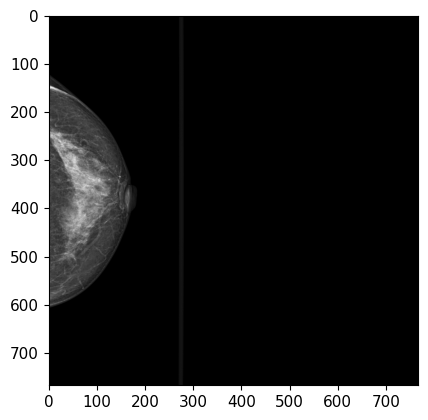

In [312]:
plt.imshow(j2k_img_window, cmap='bone')
plt.show()

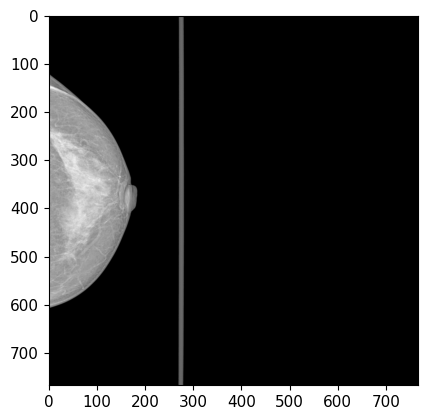

In [313]:
plt.imshow(j2k_img, cmap='bone')
plt.show()

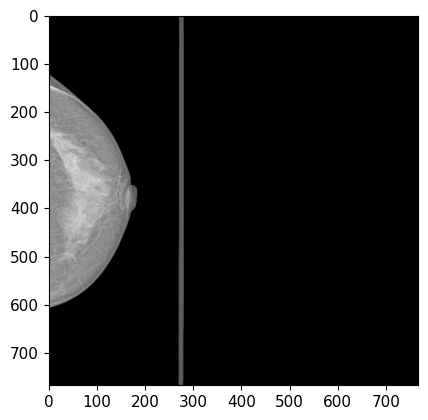

In [314]:
png_img = cv2.imread(rsna_768_images[1])
plt.imshow(png_img, cmap='bone')
plt.show()

## DALI Pipeline for jpg

In [18]:
class JpgIterator(object):
    def __init__(self, df, batch_size, img_dir):
        self.df = df
        self.batch_size = batch_size
        self.img_dir = img_dir
       
    @staticmethod
    def decompress_jpg(dm):
        info = dm.getPixelDataInfo()
        img = np.empty((info['Rows'], info['Cols']), dtype = info['dtype'])
        dm.copyFrameData(0, img)
        return img
    
    def process_img(self, img_dir, patient_id, image_id):
        dm = dicomsdl.open(f'{img_dir}/{patient_id}/{image_id}.dcm')
        return self.decompress_jpg(dm).astype(np.uint16), dm.PhotometricInterpretation == 'MONOCHROME1'
        
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):
        if self.i > len(self.df):
            raise StopIteration
        
        decompressed_imgs, is_monochrome_imgs, img_ids = [], [], []
        
        df = self.df.iloc[range(self.i, min(self.i + self.batch_size, len(self.df)))]
        
        for p_id, i_id in df[['patient_id', 'image_id']].values:
            decompressed_img, is_monochrome_img = self.process_img(self.img_dir, p_id, i_id)
            
            decompressed_imgs.append(np.expand_dims(decompressed_img, axis = 2))
            is_monochrome_imgs.append(np.array([is_monochrome_img], dtype = np.bool_))
            img_ids.append(np.array([i_id], dtype = np.int64))
            
        self.i += self.batch_size
                    
        return decompressed_imgs, is_monochrome_imgs, img_ids

In [233]:
JpgIter = JpgIterator(df=df[df["patient_id"]==10038], batch_size=4, img_dir=Config["dcm_dir"])

In [287]:
@pipeline_def
def jpg_process_pipeline(width, height):
    imgs, is_monochromes, img_ids = fn.external_source(
        source = JpgIter, num_outputs = 3, device = "gpu", dtype = [types.UINT16, types.BOOL, types.INT64],
    )
    
    imgs = fn.reinterpret(imgs, layout = "HWC")
    # the results of cv2.resize() and fn.resize() are not the same
    imgs = fn.resize(imgs, size=[width, height], device="gpu")
    
    return imgs, is_monochromes, img_ids

def jpg_pipe_postprocessing(pipe_out, idx, patient_id):
    # image id
    img_id = pipe_out[2].as_cpu().as_array().squeeze().tolist()[idx]

    # MONOCHROME1
    is_monochrom1 = pipe_out[1].as_cpu().as_array()[idx]
    
    # image post-processing
    img = pipe_out[0].as_cpu().as_array()[idx].squeeze()

    dcmfile = pydicom.dcmread(f"/home/data4/share/rsna-breast-cancer-detection/train_images/{patient_id}/{img_id}.dcm")
    img_window = apply_windowing(img, dcmfile)

    img = to_3_channels(img, is_monochrom1)
    img_window = to_3_channels(img_window, is_monochrom1)


    return img, img_window, img_id

In [243]:
pipe = jpg_process_pipeline(width=768, height=768, batch_size=4, num_threads=2, device_id=0, 
                           py_num_workers=1, exec_async=False, exec_pipelined=False)
pipe.build()

In [286]:
%%time
jpg_out = pipe.run()
jpg_img, jpg_img_window, jpg_img_id = jpg_pipe_postprocessing(jpg_out, 0, patient_id=10038)
jpg_img_id

StopIteration: 

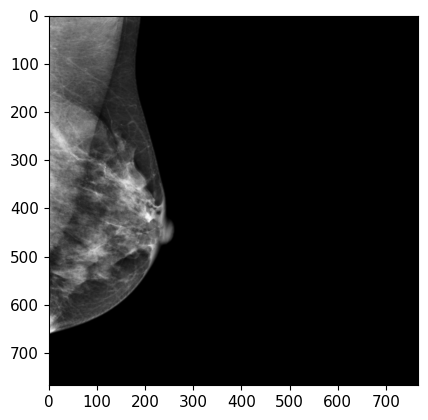

In [246]:
plt.imshow(jpg_img_window, cmap='bone')
plt.show()

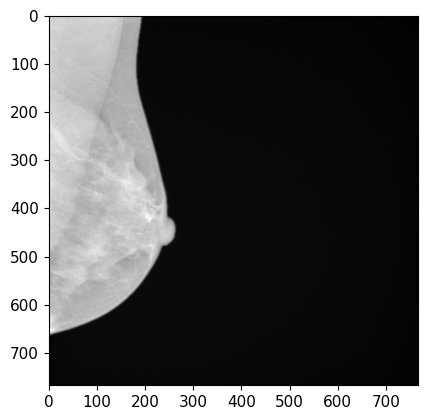

In [245]:
plt.imshow(jpg_img, cmap='bone')
plt.show()

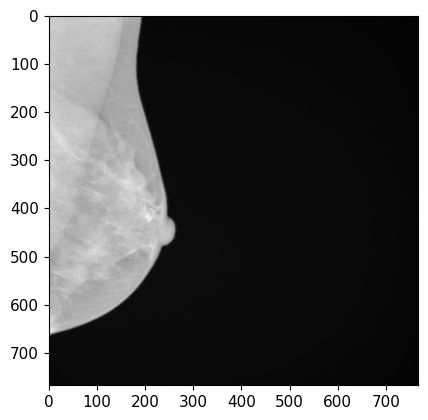

In [241]:
png_img = cv2.imread(rsna_768_images[6])
plt.imshow(png_img, cmap='bone')
plt.show()

## YOLOv5

In [130]:
if not os.path.isdir('./yolov5'):
    !git clone https://github.com/ultralytics/yolov5 

In [131]:
def get_yolo():
    b = plt.get_backend()
    model = torch.hub.load('./yolov5/', 'custom', path='./yolov5/rsna-roi-003.pt', source='local')
    matplotlib.use(b) 
    return model

In [247]:
def roi_extraction_yolov5(model, img):
    #select only best prediction
    prediction = model(img).pandas().xyxy[0].to_dict(orient='records')
    if len(prediction)==0:
        return None
        
    prediction = prediction[0]
    result = {key:prediction[key] for key in ['xmin','xmax','ymin','ymax']}
    
    if 768 - result['xmax'] < 10:
        result['xmax'] = 768
        
    if result['xmin'] < 10:
        result['xmin'] = 0
    return result

In [248]:
def roi_extraction_cv2(img):
    # Otsu's thresholding after Gaussian filtering
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(img, (5, 5), 0)
    _, breast_mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    roi = {
        "xmin": x,
        "ymin": y,
        "xmax": x + w,
        "ymax": y + h
    }
    return roi

In [315]:
def show_img_and_roi(img, roi):
    fig = plt.figure(figsize=(5, 5))
    rect = cv2.rectangle(img, (int(roi['xmin']), int(roi['ymin'])), (int(roi['xmax']), int(roi['ymax'])), (255,0,0), 4)
    
    plt.imshow(img, cmap='bone')
    plt.show()

In [250]:
roi_model = get_yolo()

YOLOv5 🚀 v7.0-312-g1bcd17ee Python-3.8.19 torch-1.13.1+cu116 CUDA:0 (Quadro RTX 8000, 48593MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


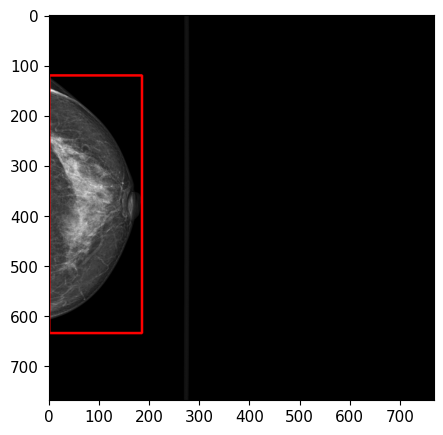

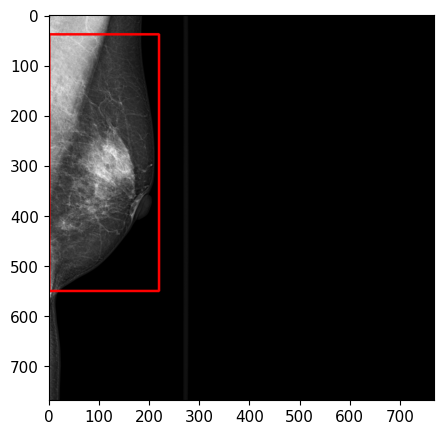

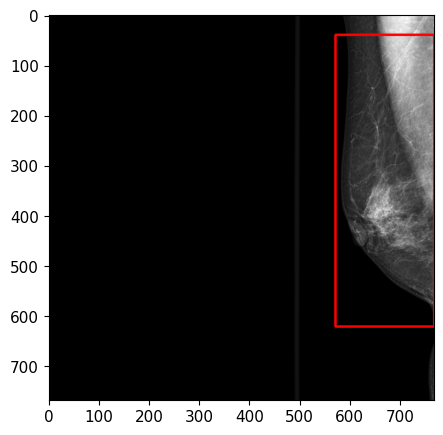

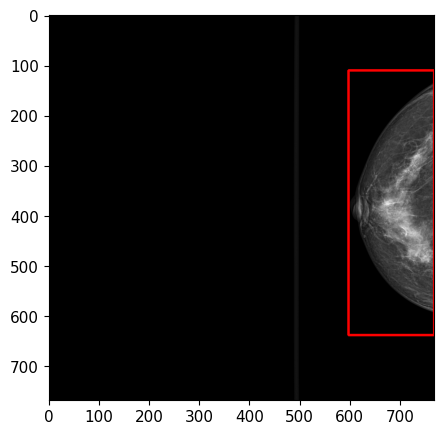

In [318]:
j2k_imgs = []
j2k_rois = []
for i in range(len(j2k_out[0])):
    j2k_img, j2k_img_window, _ = j2k_pipe_postprocessing(j2k_out, i, 10006)
    roi = roi_extraction_yolov5(roi_model, j2k_img)
    show_img_and_roi(j2k_img_window, roi)

In [335]:
jpg_imgs = []
jpg_rois = []
for i in range(len(jpg_out[0])):
    jpg_img, jpg_img_window, _ = jpg_pipe_postprocessing(jpg_out, i, 10038)
    roi = roi_extraction_yolov5(roi_model, jpg_img)

## Resize and Padding

In [448]:
def resize_and_pad(img, input_size=[2048, 1024]):
    input_h, input_w = input_size
    ori_h, ori_w = img.shape[:2]
    ratio = min(input_h / ori_h, input_w / ori_w)
    # resize
    img = torch.from_numpy(img[:,:,0])
    img = img.to(torch.float32)
    img = F.interpolate(img.view(1, 1, ori_h, ori_w),
                        mode="bilinear",
                        scale_factor=ratio,
                        recompute_scale_factor=True)[0, 0]
    # padding
    padded_img = torch.zeros((input_h, input_w),
                             dtype=img.dtype,
                             device='cuda')
    cur_h, cur_w = img.shape
    y_start = (input_h - cur_h) // 2
    x_start = (input_w - cur_w) // 2
    padded_img[y_start:y_start + cur_h, x_start:x_start + cur_w] = img
    padded_img = padded_img.unsqueeze(-1).expand(-1, -1, 3)
    padded_img = padded_img.to(torch.uint8)
    padded_img = padded_img.cpu().numpy()
    
    return padded_img

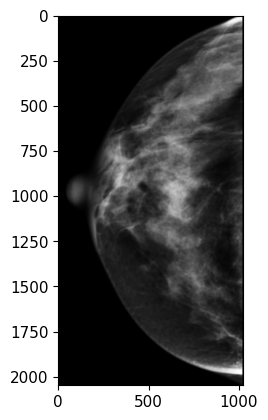

In [449]:
test_crop = crop_img(jpg_img_window, roi)
rp_img = resize_and_pad(test_crop)
plt.imshow(rp_img, cmap='bone')
plt.show()

## Crop and Save Images

In [445]:
def crop_img(img, roi):
    x, y = int(roi["xmin"]), int(roi["ymin"])
    w, h = int(roi["xmax"] - roi["xmin"]), int(roi["ymax"] - roi["ymin"])
    return img[y:y+h, x:x+w]

In [446]:
def check_mkdir(file_path, isdir:bool=False):
    path_sep_list = os.path.abspath(file_path).split(os.path.sep)

    if ':' in path_sep_list[0]:
        path_sep_list[0] = path_sep_list[0]+os.path.sep

    for depth_i in range(len(path_sep_list)):
        if depth_i >0:
            dir_path = os.path.join(*path_sep_list[:depth_i])
            if path_sep_list[0]=='':
                dir_path = '/'+dir_path
            if not os.path.exists(dir_path):
                os.mkdir(dir_path)
    if isdir:
        if not os.path.exists(file_path):
            os.mkdir(file_path)

In [454]:
# save cropped j2k images
for p_id in tqdm(df_j2k["patient_id"].unique()):
    df_subset = df[df["patient_id"]==p_id]
    subset_size = len(df_subset)
    J2kIter = J2kIterator(df=df_subset, batch_size=subset_size, img_dir=Config["dcm_dir"])
    pipe = j2k_decode_pipeline(width=768, height=768, batch_size=subset_size, num_threads=2, device_id=0, 
                               py_num_workers=1, exec_async=False, exec_pipelined=False)
    pipe.build()
    j2k_out = pipe.run()
    for i in range(len(j2k_out[0])):
        j2k_img, j2k_img_window, img_id = j2k_pipe_postprocessing(j2k_out, i, p_id)
        try:
            roi = roi_extraction_yolov5(roi_model, j2k_img)
            j2k_img_crop = crop_img(j2k_img_window, roi)
        except:
            try:
                j2k_img_gray = cv2.cvtColor(j2k_img, cv2.COLOR_BGR2GRAY)
                roi = roi_extraction_cv2(j2k_img_gray)
                j2k_img_crop = crop_img(j2k_img_window, roi)
                print("using cv2 for cropping")
            except:
                j2k_img_crop = j2k_img
                print("cropping failed...")
        j2k_img_pad = resize_and_pad(j2k_img_crop)
        save_path = f"/home/FanHuang247817/train_images_png2/{p_id}/{img_id}.png"
        check_mkdir(save_path)
        cv2.imwrite(save_path, j2k_img_pad)

  0%|▏                                                                                                                                                     | 7/6095 [00:05<1:24:49,  1.20it/s]

cropping failed...


  5%|███████▌                                                                                                                                            | 311/6095 [04:41<1:30:15,  1.07it/s]

cropping failed...


  5%|███████▋                                                                                                                                            | 318/6095 [04:47<1:31:30,  1.05it/s]

cropping failed...


 10%|██████████████▍                                                                                                                                     | 594/6095 [08:59<1:19:19,  1.16it/s]

cropping failed...


 10%|███████████████▍                                                                                                                                    | 634/6095 [09:36<1:23:17,  1.09it/s]

cropping failed...


 11%|████████████████                                                                                                                                    | 661/6095 [10:01<1:33:02,  1.03s/it]

cropping failed...


 11%|████████████████▊                                                                                                                                   | 694/6095 [10:30<1:22:13,  1.09it/s]

cropping failed...
cropping failed...


 11%|████████████████▉                                                                                                                                   | 695/6095 [10:31<1:15:14,  1.20it/s]

cropping failed...


 15%|██████████████████████▌                                                                                                                             | 929/6095 [14:06<1:14:54,  1.15it/s]

cropping failed...


 17%|█████████████████████████▋                                                                                                                         | 1063/6095 [16:09<1:11:30,  1.17it/s]

cropping failed...


 18%|█████████████████████████▊                                                                                                                         | 1068/6095 [16:14<1:10:47,  1.18it/s]

cropping failed...
cropping failed...


 18%|█████████████████████████▊                                                                                                                         | 1069/6095 [16:14<1:05:22,  1.28it/s]

cropping failed...
cropping failed...


 23%|█████████████████████████████████▌                                                                                                                 | 1394/6095 [21:14<1:18:56,  1.01s/it]

cropping failed...


 23%|██████████████████████████████████                                                                                                                 | 1413/6095 [21:31<1:05:45,  1.19it/s]

cropping failed...
cropping failed...


 23%|██████████████████████████████████▎                                                                                                                | 1424/6095 [21:41<1:10:35,  1.10it/s]

cropping failed...
cropping failed...


 27%|████████████████████████████████████████▎                                                                                                          | 1670/6095 [25:32<1:05:57,  1.12it/s]

cropping failed...


 30%|███████████████████████████████████████████▉                                                                                                       | 1822/6095 [27:55<1:04:29,  1.10it/s]

cropping failed...


 32%|██████████████████████████████████████████████▎                                                                                                    | 1922/6095 [29:31<1:12:53,  1.05s/it]

cropping failed...


 34%|█████████████████████████████████████████████████▍                                                                                                 | 2050/6095 [31:30<1:05:31,  1.03it/s]

cropping failed...
cropping failed...


 34%|██████████████████████████████████████████████████▍                                                                                                | 2091/6095 [32:08<1:05:28,  1.02it/s]

cropping failed...
cropping failed...


 34%|███████████████████████████████████████████████████▏                                                                                                 | 2092/6095 [32:09<59:15,  1.13it/s]

cropping failed...


 36%|██████████████████████████████████████████████████████▏                                                                                              | 2215/6095 [34:04<55:54,  1.16it/s]

cropping failed...


 38%|███████████████████████████████████████████████████████▏                                                                                           | 2289/6095 [35:14<1:00:04,  1.06it/s]

cropping failed...


 43%|███████████████████████████████████████████████████████████████▊                                                                                     | 2608/6095 [40:11<51:21,  1.13it/s]

cropping failed...


 49%|█████████████████████████████████████████████████████████████████████████▎                                                                           | 2997/6095 [46:10<45:09,  1.14it/s]

cropping failed...
cropping failed...


 51%|████████████████████████████████████████████████████████████████████████████                                                                         | 3111/6095 [47:54<43:30,  1.14it/s]

cropping failed...
cropping failed...


 51%|████████████████████████████████████████████████████████████████████████████                                                                         | 3112/6095 [47:55<43:39,  1.14it/s]

cropping failed...


 51%|████████████████████████████████████████████████████████████████████████████▍                                                                        | 3125/6095 [48:07<46:48,  1.06it/s]

cropping failed...


 51%|████████████████████████████████████████████████████████████████████████████▍                                                                        | 3126/6095 [48:07<42:53,  1.15it/s]

cropping failed...


 52%|██████████████████████████████████████████████████████████████████████████████                                                                       | 3191/6095 [49:07<44:22,  1.09it/s]

cropping failed...


 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                      | 3208/6095 [49:22<43:30,  1.11it/s]

cropping failed...
cropping failed...


 53%|██████████████████████████████████████████████████████████████████████████████▍                                                                      | 3209/6095 [49:23<39:34,  1.22it/s]

cropping failed...
cropping failed...


 53%|███████████████████████████████████████████████████████████████████████████████▏                                                                     | 3237/6095 [49:49<45:07,  1.06it/s]

cropping failed...


 54%|███████████████████████████████████████████████████████████████████████████████▉                                                                     | 3269/6095 [50:17<41:23,  1.14it/s]

cropping failed...


 56%|██████████████████████████████████████████████████████████████████████████████████▉                                                                  | 3394/6095 [52:11<41:42,  1.08it/s]

cropping failed...


 60%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 3667/6095 [56:25<39:51,  1.02it/s]

cropping failed...


 63%|██████████████████████████████████████████████████████████████████████████████████████████████                                                       | 3846/6095 [59:09<32:45,  1.14it/s]

cropping failed...


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 4038/6095 [1:02:09<32:37,  1.05it/s]

cropping failed...


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 4249/6095 [1:05:24<29:20,  1.05it/s]

cropping failed...


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 4342/6095 [1:06:50<25:57,  1.13it/s]

cropping failed...
cropping failed...


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 4343/6095 [1:06:51<24:09,  1.21it/s]

cropping failed...


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 4627/6095 [1:11:12<22:39,  1.08it/s]

cropping failed...


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 4646/6095 [1:11:29<20:49,  1.16it/s]

cropping failed...


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 4763/6095 [1:13:19<20:35,  1.08it/s]

cropping failed...


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 5052/6095 [1:17:45<15:19,  1.13it/s]

cropping failed...
cropping failed...


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5111/6095 [1:18:39<14:48,  1.11it/s]

cropping failed...
cropping failed...


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 5112/6095 [1:18:40<13:24,  1.22it/s]

cropping failed...
cropping failed...


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 5142/6095 [1:19:07<14:05,  1.13it/s]

cropping failed...


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 5168/6095 [1:19:32<16:08,  1.04s/it]

cropping failed...
cropping failed...


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 5268/6095 [1:21:03<12:17,  1.12it/s]

cropping failed...
cropping failed...
cropping failed...
cropping failed...


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 5368/6095 [1:22:37<11:38,  1.04it/s]

cropping failed...


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 5594/6095 [1:26:05<07:17,  1.14it/s]

cropping failed...


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 5643/6095 [1:26:49<06:23,  1.18it/s]

cropping failed...


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 5646/6095 [1:26:51<06:19,  1.18it/s]

cropping failed...


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 5769/6095 [1:28:45<04:59,  1.09it/s]

cropping failed...


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5874/6095 [1:30:20<03:27,  1.07it/s]

cropping failed...


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 5875/6095 [1:30:21<03:24,  1.07it/s]

cropping failed...


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 5978/6095 [1:31:55<01:44,  1.12it/s]

cropping failed...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6095/6095 [1:33:42<00:00,  1.08it/s]


In [455]:
# save cropped jpg images
for p_id in tqdm(df_jpg["patient_id"].unique()):
    df_subset = df[df["patient_id"]==p_id]
    subset_size = len(df_subset)
    JpgIter = JpgIterator(df=df_subset, batch_size=subset_size, img_dir=Config["dcm_dir"])
    pipe = jpg_process_pipeline(width=768, height=768, batch_size=subset_size, num_threads=2, device_id=0, 
                               py_num_workers=1, exec_async=False, exec_pipelined=False)
    pipe.build()
    jpg_out = pipe.run()
    for i in range(len(jpg_out[0])):
        jpg_img, jpg_img_window, img_id = jpg_pipe_postprocessing(jpg_out, i, p_id)
        try:
            roi = roi_extraction_yolov5(roi_model, jpg_img)
            jpg_img_crop = crop_img(jpg_img_window, roi)
        except:
            try:
                jpg_img_gray = cv2.cvtColor(jpg_img, cv2.COLOR_BGR2GRAY)
                roi = roi_extraction_cv2(jpg_img_gray)
                jpg_img_crop = crop_img(jpg_img_window, roi)
                print("using cv2 for cropping")
            except:
                jpg_img_crop = jpg_img
                print("cropping failed...")
        jpg_img_pad = resize_and_pad(jpg_img_crop)
        save_path = f"/home/FanHuang247817/train_images_png2/{p_id}/{img_id}.png"
        check_mkdir(save_path)
        cv2.imwrite(save_path, jpg_img_pad)

  4%|█████▋                                                                                                                                              | 222/5818 [06:46<3:39:04,  2.35s/it]

cropping failed...


  5%|████████                                                                                                                                            | 316/5818 [09:28<2:36:19,  1.70s/it]

cropping failed...


  9%|████████████▋                                                                                                                                       | 501/5818 [14:56<2:41:54,  1.83s/it]

cropping failed...


  9%|█████████████                                                                                                                                       | 515/5818 [15:22<3:12:07,  2.17s/it]

cropping failed...


 11%|████████████████                                                                                                                                    | 632/5818 [18:48<2:34:03,  1.78s/it]

cropping failed...


 11%|████████████████▎                                                                                                                                   | 641/5818 [19:05<3:04:29,  2.14s/it]

cropping failed...


 12%|█████████████████▌                                                                                                                                  | 688/5818 [20:32<2:49:21,  1.98s/it]

cropping failed...


 13%|███████████████████▋                                                                                                                                | 776/5818 [23:16<1:50:57,  1.32s/it]

cropping failed...


 16%|███████████████████████                                                                                                                             | 908/5818 [27:14<2:21:25,  1.73s/it]

cropping failed...


 18%|█████████████████████████▊                                                                                                                         | 1021/5818 [30:34<2:12:45,  1.66s/it]

cropping failed...


 18%|███████████████████████████                                                                                                                        | 1069/5818 [32:03<2:41:55,  2.05s/it]

cropping failed...


 20%|█████████████████████████████▍                                                                                                                     | 1164/5818 [34:59<2:03:26,  1.59s/it]

cropping failed...


 21%|███████████████████████████████▎                                                                                                                   | 1237/5818 [37:13<2:04:55,  1.64s/it]

cropping failed...


 22%|███████████████████████████████▊                                                                                                                   | 1258/5818 [37:48<1:38:43,  1.30s/it]

cropping failed...


 23%|█████████████████████████████████▌                                                                                                                 | 1328/5818 [39:55<2:19:29,  1.86s/it]

cropping failed...


 25%|████████████████████████████████████▉                                                                                                              | 1464/5818 [43:59<1:44:59,  1.45s/it]

cropping failed...


 26%|██████████████████████████████████████▏                                                                                                            | 1513/5818 [45:30<2:38:36,  2.21s/it]

cropping failed...


 26%|██████████████████████████████████████▎                                                                                                            | 1518/5818 [45:38<1:55:55,  1.62s/it]

cropping failed...


 27%|██████████████████████████████████████▉                                                                                                            | 1543/5818 [46:21<1:59:41,  1.68s/it]

cropping failed...


 28%|████████████████████████████████████████▌                                                                                                          | 1603/5818 [48:07<1:42:26,  1.46s/it]

cropping failed...


 28%|█████████████████████████████████████████▋                                                                                                         | 1650/5818 [49:31<3:08:24,  2.71s/it]

cropping failed...


 28%|█████████████████████████████████████████▊                                                                                                         | 1655/5818 [49:44<2:41:12,  2.32s/it]

cropping failed...


 29%|██████████████████████████████████████████                                                                                                         | 1663/5818 [50:00<2:10:40,  1.89s/it]

cropping failed...


 29%|██████████████████████████████████████████▎                                                                                                        | 1673/5818 [50:17<1:57:22,  1.70s/it]

cropping failed...


 30%|███████████████████████████████████████████▉                                                                                                       | 1737/5818 [52:14<1:34:41,  1.39s/it]

cropping failed...


 31%|█████████████████████████████████████████████▊                                                                                                     | 1812/5818 [54:27<1:46:40,  1.60s/it]

cropping failed...


 32%|███████████████████████████████████████████████▋                                                                                                   | 1889/5818 [57:02<1:45:22,  1.61s/it]

cropping failed...


 34%|█████████████████████████████████████████████████▋                                                                                                 | 1968/5818 [59:24<1:35:27,  1.49s/it]

cropping failed...


 36%|████████████████████████████████████████████████████▌                                                                                            | 2109/5818 [1:03:41<1:47:36,  1.74s/it]

cropping failed...


 36%|████████████████████████████████████████████████████▋                                                                                            | 2113/5818 [1:03:47<1:28:16,  1.43s/it]

cropping failed...


 37%|█████████████████████████████████████████████████████▌                                                                                           | 2147/5818 [1:04:46<2:01:55,  1.99s/it]

cropping failed...


 38%|███████████████████████████████████████████████████████▊                                                                                         | 2237/5818 [1:07:30<1:37:30,  1.63s/it]

cropping failed...


 40%|█████████████████████████████████████████████████████████▊                                                                                       | 2322/5818 [1:10:09<2:00:04,  2.06s/it]

cropping failed...


 40%|█████████████████████████████████████████████████████████▉                                                                                       | 2327/5818 [1:10:15<1:14:43,  1.28s/it]

cropping failed...


 41%|██████████████████████████████████████████████████████████▉                                                                                      | 2363/5818 [1:11:15<1:23:33,  1.45s/it]

cropping failed...


 41%|███████████████████████████████████████████████████████████▎                                                                                     | 2382/5818 [1:11:50<1:39:52,  1.74s/it]

cropping failed...


 43%|█████████████████████████████████████████████████████████████▋                                                                                   | 2473/5818 [1:14:29<1:37:31,  1.75s/it]

cropping failed...


 43%|█████████████████████████████████████████████████████████████▊                                                                                   | 2479/5818 [1:14:37<1:27:42,  1.58s/it]

cropping failed...


 43%|██████████████████████████████████████████████████████████████▉                                                                                  | 2524/5818 [1:15:58<2:16:56,  2.49s/it]

cropping failed...


 45%|█████████████████████████████████████████████████████████████████▉                                                                               | 2646/5818 [1:19:38<1:17:55,  1.47s/it]

cropping failed...


 46%|█████████████████████████████████████████████████████████████████▉                                                                               | 2648/5818 [1:19:42<1:35:08,  1.80s/it]

cropping failed...


 46%|██████████████████████████████████████████████████████████████████▌                                                                              | 2673/5818 [1:20:24<1:16:03,  1.45s/it]

cropping failed...


 46%|██████████████████████████████████████████████████████████████████▋                                                                              | 2677/5818 [1:20:31<1:27:58,  1.68s/it]

cropping failed...


 46%|██████████████████████████████████████████████████████████████████▊                                                                              | 2680/5818 [1:20:37<1:27:23,  1.67s/it]

cropping failed...


 47%|████████████████████████████████████████████████████████████████████                                                                             | 2730/5818 [1:22:06<1:26:50,  1.69s/it]

cropping failed...


 47%|████████████████████████████████████████████████████████████████████▊                                                                            | 2762/5818 [1:23:01<1:12:10,  1.42s/it]

cropping failed...


 49%|███████████████████████████████████████████████████████████████████████▏                                                                         | 2854/5818 [1:25:48<1:08:24,  1.38s/it]

cropping failed...


 49%|███████████████████████████████████████████████████████████████████████▌                                                                         | 2869/5818 [1:26:16<1:27:17,  1.78s/it]

cropping failed...


 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                   | 3120/5818 [1:34:21<1:33:55,  2.09s/it]

cropping failed...


 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                  | 3139/5818 [1:34:52<1:06:18,  1.49s/it]

cropping failed...


 55%|████████████████████████████████████████████████████████████████████████████████                                                                 | 3212/5818 [1:37:05<1:03:20,  1.46s/it]

cropping failed...


 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                              | 3315/5818 [1:40:25<1:50:10,  2.64s/it]

cropping failed...


 57%|██████████████████████████████████████████████████████████████████████████████████▉                                                              | 3328/5818 [1:40:47<1:08:02,  1.64s/it]

cropping failed...


 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                           | 3418/5818 [1:43:34<1:11:28,  1.79s/it]

cropping failed...


 59%|█████████████████████████████████████████████████████████████████████████████████████▎                                                           | 3422/5818 [1:43:42<1:38:56,  2.48s/it]

cropping failed...


 60%|██████████████████████████████████████████████████████████████████████████████████████▌                                                          | 3475/5818 [1:45:30<1:14:12,  1.90s/it]

cropping failed...


 60%|██████████████████████████████████████████████████████████████████████████████████████▋                                                          | 3479/5818 [1:45:38<1:09:00,  1.77s/it]

cropping failed...


 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 3611/5818 [1:49:43<1:06:02,  1.80s/it]

cropping failed...


 62%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 3631/5818 [1:50:22<52:34,  1.44s/it]

cropping failed...


 63%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 3689/5818 [1:52:13<50:12,  1.42s/it]

cropping failed...


 64%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 3728/5818 [1:53:23<55:37,  1.60s/it]

cropping failed...


 65%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 3791/5818 [1:55:15<49:09,  1.46s/it]

cropping failed...


 65%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 3795/5818 [1:55:21<50:14,  1.49s/it]

cropping failed...


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 3915/5818 [1:58:47<47:52,  1.51s/it]

cropping failed...


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 3930/5818 [1:59:11<51:26,  1.63s/it]

cropping failed...


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 3957/5818 [1:59:57<49:43,  1.60s/it]

cropping failed...


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 3960/5818 [2:00:01<51:38,  1.67s/it]

cropping failed...


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 3971/5818 [2:00:22<49:59,  1.62s/it]

cropping failed...


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3987/5818 [2:00:52<1:12:25,  2.37s/it]

cropping failed...


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 4009/5818 [2:01:35<1:00:06,  1.99s/it]

cropping failed...


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 4036/5818 [2:02:20<55:41,  1.88s/it]

cropping failed...


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 4054/5818 [2:02:52<1:00:47,  2.07s/it]

cropping failed...


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 4062/5818 [2:03:07<51:57,  1.78s/it]

cropping failed...


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 4177/5818 [2:06:31<40:28,  1.48s/it]

cropping failed...


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 4225/5818 [2:08:04<38:50,  1.46s/it]

cropping failed...


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 4253/5818 [2:08:54<41:52,  1.61s/it]

cropping failed...


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 4296/5818 [2:10:12<44:19,  1.75s/it]

cropping failed...


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 4323/5818 [2:10:57<42:02,  1.69s/it]

cropping failed...


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 4338/5818 [2:11:26<37:58,  1.54s/it]

cropping failed...


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 4377/5818 [2:12:33<44:53,  1.87s/it]

cropping failed...


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 4414/5818 [2:13:40<41:49,  1.79s/it]

cropping failed...


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 4607/5818 [2:19:19<29:19,  1.45s/it]

cropping failed...


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 4660/5818 [2:20:58<36:37,  1.90s/it]

cropping failed...


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 4872/5818 [2:27:22<25:30,  1.62s/it]

cropping failed...


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 4890/5818 [2:27:56<28:14,  1.83s/it]

cropping failed...


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 4948/5818 [2:29:31<20:49,  1.44s/it]

cropping failed...


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 5045/5818 [2:32:36<22:26,  1.74s/it]

cropping failed...


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 5459/5818 [2:45:02<12:17,  2.05s/it]

cropping failed...


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 5520/5818 [2:46:53<08:42,  1.75s/it]

cropping failed...


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 5564/5818 [2:48:23<08:41,  2.05s/it]

cropping failed...


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 5566/5818 [2:48:27<07:30,  1.79s/it]

cropping failed...


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 5649/5818 [2:50:39<04:03,  1.44s/it]/tmp/ipykernel_43897/4017234273.py:2: RuntimeWarning: invalid value encountered in divide
  img = (img - img.min()) / (img.max() - img.min())
/tmp/ipykernel_43897/4017234273.py:14: RuntimeWarning: invalid value encountered in cast
  return img_3c.astype(np.uint8)
 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5650/5818 [2:50:41<04:29,  1.61s/it]

cropping failed...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5666/5818 [2:51:08<04:16,  1.69s/it]

cropping failed...


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 5667/5818 [2:51:13<06:28,  2.57s/it]

cropping failed...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5818/5818 [2:55:49<00:00,  1.81s/it]


In [484]:
# create a subset for missing jpg images
# missing_image_ids = []
# for p_id in tqdm(df_jpg["patient_id"].unique()):
#     df_subset = df[df["patient_id"]==p_id]
#     for image_id in df_subset["image_id"].unique():
#         if not os.path.exists(f"/home/FanHuang247817/train_images_png2/{p_id}/{image_id}.png"):
#             missing_image_ids.append(image_id)
    
# df_jpg_subset = df_jpg[df_jpg['image_id'].isin(missing_image_ids)].reset_index(drop=True)

# for p_id in tqdm(df_jpg_subset["patient_id"].unique()):
#     df_subset = df[df["patient_id"]==p_id]
#     subset_size = len(df_subset)
#     JpgIter = JpgIterator(df=df_subset, batch_size=subset_size, img_dir=Config["dcm_dir"])
#     pipe = jpg_process_pipeline(width=768, height=768, batch_size=subset_size, num_threads=2, device_id=0, 
#                                py_num_workers=1, exec_async=False, exec_pipelined=False)
#     pipe.build()
#     jpg_out = pipe.run()
#     for i in range(len(jpg_out[0])):
#         jpg_img, jpg_img_window, img_id = jpg_pipe_postprocessing(jpg_out, i, p_id)
#         if not os.path.exists(f"/home/FanHuang247817/train_images_png2/{p_id}/{img_id}.png"):
#             try:
#                 roi = roi_extraction_yolov5(roi_model, jpg_img)
#                 jpg_img_crop = crop_img(jpg_img_window, roi)
#             except:
#                 try:
#                     jpg_img_gray = cv2.cvtColor(jpg_img, cv2.COLOR_BGR2GRAY)
#                     roi = roi_extraction_cv2(jpg_img_gray)
#                     jpg_img_crop = crop_img(jpg_img_window, roi)
#                     print("using cv2 for cropping")
#                 except:
#                     jpg_img_crop = jpg_img
#                     print("cropping failed...")
#             jpg_img_pad = resize_and_pad(jpg_img_crop)
#             save_path = f"/home/FanHuang247817/train_images_png2/{p_id}/{img_id}.png"
#             check_mkdir(save_path)
#             cv2.imwrite(save_path, jpg_img_pad)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5818/5818 [00:03<00:00, 1556.37it/s]


467

In [492]:
len(df) - len(glob.glob(f"/home/FanHuang247817/train_images_png2/*/*.png"))

0

## Decode of lossless jpg is not currenly supported by nvjpeg on gpu!!!

In [210]:
df_train = pd.read_csv('/home/data4/share/rsna-breast-cancer-detection/train.csv')
train_img_dir = "/home/data4/share/rsna-breast-cancer-detection/train_images"
df_train = df_train[df_train["patient_id"]==127]

In [267]:
class JpgIterator(object):
    
    def __init__(self, df, batch_size, img_dir):
        self.df = df
        self.batch_size = batch_size
        self.img_dir = img_dir

    @staticmethod
    def dicom_to_jpg(img_dir, patient_id, image_id):
        dcmfile = pydicom.dcmread(f'{img_dir}/{patient_id}/{image_id}.dcm')
        
        if dcmfile.file_meta.TransferSyntaxUID == '1.2.840.10008.1.2.4.70':
            with open(f'{img_dir}/{patient_id}/{image_id}.dcm', 'rb') as fp:
                raw = DicomBytesIO(fp.read())
                ds = pydicom.dcmread(raw)
            offset = ds.PixelData.find(b"\xff\xd8\xff\xe0")

            return np.frombuffer(ds.PixelData[offset:], dtype=np.uint8), dcmfile.PhotometricInterpretation == 'MONOCHROME1'

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):
        if self.i > len(self.df):
            raise StopIteration

        compressed_imgs, is_monochrome_imgs = [], []
        patient_ids, img_ids = [], []

        batch_start, batch_finish = self.i, min(self.i + self.batch_size, len(self.df))
        df_batch = self.df.iloc[range(batch_start, batch_finish)]

        for patient_id, img_id in df_batch[["patient_id", "image_id"]].values:
            compressed_img, is_monochrome_img = self.dicom_to_jpg(self.img_dir, patient_id, img_id)

            compressed_imgs.append(compressed_img)
            is_monochrome_imgs.append(np.array([is_monochrome_img], dtype = np.bool_))

            patient_ids.append(np.array([patient_id], dtype = np.int64))
            img_ids.append(np.array([img_id], dtype = np.int64))

        self.i += self.batch_size

        return compressed_imgs, is_monochrome_imgs, patient_ids, img_ids

In [268]:
JpgIter = JpgIterator(df=df_train.iloc[[0]], batch_size=1, img_dir=train_img_dir)

In [272]:
@pipeline_def
def jpeg_decode_pipeline():
    imgs, is_monochromes, p_ids, i_ids = fn.external_source(
        source=JpgIter, num_outputs=4, device="cpu", dtype=[types.UINT8, types.BOOL, types.INT64, types.INT64]
    )

    imgs = fn.experimental.decoders.image(
        imgs, device='mixed', output_type=types.ANY_DATA, dtype=DALIDataType.UINT16
    )
    
    return imgs, is_monochromes, p_ids, i_ids

In [273]:
pipe = jpg_decode_pipeline(batch_size=1, num_threads=1, device_id=0, 
                           py_num_workers=1, exec_async=False, exec_pipelined=False)
pipe.build()

In [274]:
out = pipe.run()

RuntimeError: Critical error in pipeline:
Error in MIXED operator `nvidia.dali.fn.experimental.decoders.image`,
which was used in the pipeline definition with the following traceback:

  File "/tmp/ipykernel_6107/3913241424.py", line 7, in jpeg_decode_pipeline
    imgs = fn.experimental.decoders.image(

encountered:

Failed to decode sample #0 : 
Current pipeline object is no longer valid.